## To do
- Read the paper and understand the experiment
- Study expression for significant histones within 5000 bases
- Pick up gradient boosting
- Apply PCA for preprocessing and on results of SVC
- Check the trained classifiers on test dataset

## Done
- Performed kernel PCA on the minmaxscaled log X_train dataset
    - No separation revealed
- Ran paramGridSearch on Random forest and achieved 0.56 (+/- 0.03) accuracy with min_sample split of 100
- Created a pipiline of standard scaler and SVC using RBF for 5Kfold cross-validation
- Ran paramGridSearch on SVC with cross-validation and found optimum params {"C":1,"gamma":0.1} with cross-validation accuracy of 0.55 (+/- 0.01)
- take log10 of all position features and normalize
- then applied logistic regression
- Apply the stratified shuffle split during cross validation

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import StratifiedShuffleSplit,StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler,minmax_scale
from sklearn.linear_model import LogisticRegression
from sklearn import svm
#from sklearn import grid_search
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from time import time
from sklearn.decomposition import PCA, KernelPCA

In [18]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [19]:
cd ~/CRG

/home/etiavlovsky/CRG


In [30]:
%run scripts/dataset_processing.py
features = load_feature_names("Features.txt")

In [64]:
%run scripts/dataset_processing.py
print dataset_processing_pipeline("Jurkat_BHIVE_mini_expr.txt")


Importing features from files
	Computing feature: row_sum
	Computing feature: gmfpt
	Computing feature: c_decay

Encoding categorical values
There are 5 unique values for "cat" feature.

['AG' 'AP' 'EN' 'IN' 'SG']
There are 2 unique values for "strand" feature.

['+' '-']

Extracting target values
Binary label split: 0.51
(11378,)

Dropping features

Handling NaNs
433
(11378, 79)
Spliting into train and test and saving the datasets
(10229,)
(1149,)
None


In [5]:
print features['H3K9me3_GSE65687']
print features['mapq']

distance from closest H3K9me3_GSE65687 mark
barcode-locus assignment score


Reading the train dataset and extracting the feature names

In [21]:
df = pd.read_table("Jurkat_hiv_50kb.txt",comment="#")
#df = pd.read_table("train-Jurkat_BHIVE_mini_expr.txt")
#df = pd.read_table("/mnt/shared/data/MachineLearning/Jurkat_hiv_train_50kb.txt",comment="#")
print df.shape
column_names = df.columns.tolist()
df.head()

(11378, 315)


,brcd,chrom,pos,strand,nread,mapq,cat,gene_name,d_actgen,d_acttss,...,TCF12_GSE29181_hb,TCF12_GSE29181_hb_r,TCF3_GSE29181_zb,TCF3_GSE29181_zb_r,TCF3_GSE29181_hb,TCF3_GSE29181_hb_r,UTX_GSE72300_zb,UTX_GSE72300_zb_r,UTX_GSE72300_hb,UTX_GSE72300_hb_r
0,ACATATGATTAGGATT,chr1,721406,-,2539,26,IN,NaN,158177,173282,...,13,0.030374,3,0.007009,1,0.002336,617,1.441589,188,0.439252
1,CAGGGGATGGCTCGGATGGG,chr1,752311,+,121,13,IN,NaN,127272,142377,...,57,0.046042,4,0.003231,2,0.001616,1554,1.255250,509,0.411147
2,ATTCGCGGTCTTGTTTG,chr1,761612,+,1988,22,IN,NaN,117971,133076,...,57,0.046042,4,0.003231,2,0.001616,1554,1.255250,509,0.411147
3,GATGATATTAGTGACTTAAG,chr1,765174,-,56,13,EN,NaN,114409,129514,...,57,0.046042,4,0.003231,2,0.001616,1554,1.255250,509,0.411147
4,AGGAAGGATGACGTAATGTT,chr1,778623,-,584,22,EN,NaN,100960,116065,...,57,0.046042,4,0.003231,2,0.001616,1554,1.255250,509,0.411147


### Looking at integration count for each chromosome

In [3]:
#chr_expr = df.groupby("chrom")["expr"]#.agg(["count","mean","std","median","min","max"])
#print chr_expr.agg(["count","mean","std","median","min","max"])
#df.boxplot(column="expr",by = "chrom",figsize=(15,10))

In [4]:
#chr_count = chr_expr.count().sort_values()
#plt.figure(figsize=(15,10))
#plt.xticks(range(len(chr_count.values)),chr_count.index.tolist())
#plt.plot(chr_count.values,"o")
#plt.show

In [5]:
#mapq_expr = df.groupby("H3K4me3")["expr"]#.agg(["count","mean","std","median","min","max"])
#print mapq_expr.agg(["count","mean","std","median","min","max"])
#df.boxplot(column="nread",by = "mapq",figsize=(15,10))
#df[df.H3K4me3 < 5000].plot("H3K4me3","expr",kind = "scatter")

Features with NaN values.
gene_name explained
other NaN because given mark does not exist in given chromosome. Substitute with plus infinity or remove this feature for samples that do not have it.

In [43]:
#nan_columns = df.isnull().any(axis = 0).index[df.isnull().any(axis = 0) == True].tolist()
#for feature in nan_columns:
#    print feature,":", features[feature],"\n",df[feature].max()

## Creating dummy one-hot variables

In [22]:
%run scripts/dataset_processing.py
cat_features = ["cat","strand"]
df = encode_one_hot(df,cat_features)
df.head()

There are 5 unique values for "cat" feature.

['AG' 'AP' 'EN' 'IN' 'SG']
There are 2 unique values for "strand" feature.

['+' '-']


,brcd,chrom,pos,nread,mapq,gene_name,d_actgen,d_acttss,d_silgen,d_siltss,...,TCF3_GSE29181_hb_r,UTX_GSE72300_zb,UTX_GSE72300_zb_r,UTX_GSE72300_hb,UTX_GSE72300_hb_r,cat_AP,cat_EN,cat_IN,cat_SG,strand_-
0,ACATATGATTAGGATT,chr1,721406,2539,26,NaN,158177,173282,17125,17730,...,0.002336,617,1.441589,188,0.439252,0,0,1,0,1
1,CAGGGGATGGCTCGGATGGG,chr1,752311,121,13,NaN,127272,142377,13173,13173,...,0.001616,1554,1.255250,509,0.411147,0,0,1,0,0
2,ATTCGCGGTCTTGTTTG,chr1,761612,1988,22,NaN,117971,133076,22474,22474,...,0.001616,1554,1.255250,509,0.411147,0,0,1,0,0
3,GATGATATTAGTGACTTAAG,chr1,765174,56,13,NaN,114409,129514,26036,26036,...,0.001616,1554,1.255250,509,0.411147,0,1,0,0,1
4,AGGAAGGATGACGTAATGTT,chr1,778623,584,22,NaN,100960,116065,39419,39419,...,0.001616,1554,1.255250,509,0.411147,0,1,0,0,1


## Adding GMFPT and Contact decay features

In [23]:
resolution = {'100kb': 100000, '10kb': 10000, '500kb': 50000, '50kb': 50000}

In [24]:
%run /home/etiavlovsky/CRG/scripts/dataset_processing.py
#%run scripts/file_processing.py

res = "50kb"
#bins = (df["pos"]/resolution[res]).astype(np.int).values
directory = "/mnt/shared/data/HiC_processing/"
feature_filenames = {"c_decay":"contacts_decay_Jurkat_",\
                     "gmfpt":"gmfpt_feature_Jurkat_",\
                     "row_sum":"row_sum_Jurkat_"}

df = import_features(df,res,directory,feature_filenames)
column_names = df.columns.tolist()

Computing feature: row_sum
Computing feature: gmfpt
Computing feature: c_decay


In [25]:
# split into train and test datasets
%run ~/CRG/scripts/table_processing.py
train_idx,test_idx = train_test_split(df,0.8)

In [26]:
df.shape

(11378, 321)

In [36]:
# select training set
df_train = df.ix[train_idx,:]
print df_train.shape
df_train.to_csv("Jurkat_hiv_train_50kb.txt",sep="\t",index=False)
del df_train

(9092, 321)


In [42]:
df_train = pd.read_csv("Jurkat_hiv_test_50kb.txt",sep="\t",)
df_train.shape

(2286, 319)

In [43]:
del df_train

In [41]:
# select training set
df_test = df.ix[test_idx,:]
drop_features(df_test,["RNA","expr"])
print df_test.shape
print df_test.head()
df_test.to_csv("Jurkat_hiv_test_50kb.txt",sep="\t",index=False)
del df_test

      RNA      expr
17    917  0.140478
20   4444  0.100316
21   1524  0.051242
22   3858  0.184996
23  15555  0.394319
(2286, 319)
                    brcd chrom      pos  nread  mapq gene_name  d_actgen  \
17   CGCAGCCGACGTACCGACG  chr1  1278044    141   100      DVL1         0   
20  TTGATTCTACCTCAGGGAGA  chr1  1327159   3930    28     CCNL2         0   
21  GCCTCACACATTTGAGACCC  chr1  1329333    638    25     CCNL2         0   
22  GGATGGACTTCGGATCTTAA  chr1  1452503    216   100    ATAD3A         0   
23      CTCCCTCGTTGGCGGC  chr1  1455991     21    13    ATAD3A         0   

    d_acttss  d_silgen  d_siltss   ...     UTX_GSE72300_hb  UTX_GSE72300_hb_r  \
17      6685      7357     11349   ...                 465           0.445402   
20      7548     26640     29989   ...                 534           0.442786   
21      5374     24466     27815   ...                 534           0.442786   
22      4971     18050     23329   ...                 507           0.440104   
23    

In [26]:
%run scripts/dataset_processing.py
y = get_target_values(df)
df.head()

KeyError: 'RNA'

In [9]:
y_train = encode_target_values(df_train)
print y_train
df_train.head()

Label split: 0.51
(9902,)
[ 1.  0.  1. ...,  0.  1.  1.]


,brcd,chrom,pos,strand,nread,mapq,cat,gene_name,d_actgen,d_acttss,...,RNA,expr,AG,AP,EN,SG,Stand +,in_gene,RNA/DNA,pos_expr
0,AAACACGGCCTTGCCTTTT,chr11,66913386,-,1172,31,AG,KDM2A,0,26645,...,981,0.382298,1.0,0.0,0.0,0.0,0.0,1.0,7.160584,1.0
1,AAACAGCTAAATTCCGG,chr6,97617243,+,1737,19,AG,MMS22L,0,113849,...,785,-0.548592,1.0,0.0,0.0,0.0,1.0,1.0,0.839572,0.0
2,AAACGAGCGGCTCAATAAGG,chr22,40268421,+,4112,31,SG,ENTHD1,28664,28664,...,49790,0.392111,0.0,0.0,0.0,1.0,1.0,1.0,7.324213,1.0
3,AAACTACATCTAGTAGTCTA,chr1,229585998,+,1170,26,AG,NUP133,0,16152,...,9506,-0.034481,1.0,0.0,0.0,0.0,1.0,1.0,2.742643,0.0
4,AAACTGACTGATTGAATGCC,chr17,36374093,-,14902,28,AG,RP11-1407O15.2,0,15926,...,19513,0.125444,1.0,0.0,0.0,0.0,0.0,1.0,3.963640,1.0


In [67]:
y_test = encode_target_values(df_test)
print y_test
df_test.head()

Label split: 0.51
(2979,)
[ 0.  1.  0. ...,  0.  1.  0.]


,brcd,chrom,pos,strand,nread,mapq,cat,gene_name,d_actgen,d_acttss,...,DNA,RNA,AG,AP,EN,SG,Stand +,in_gene,RNA/DNA,pos_expr
0,AAAAGAGCCCATCCGG,chr2,231199652,+,763,100,AG,SP140L,0,7752,...,1439,90,1.0,0.0,0.0,0.0,1.0,1.0,0.062543,0.0
1,AAAATAGCAGTTCCCTAGTA,chr1,230393530,+,1780,29,EN,GALNT2,0,167944,...,3348,17864,0.0,0.0,1.0,0.0,1.0,1.0,5.335723,1.0
2,AAACAGAATTATTAATCGTC,chrX,44172515,-,7157,34,SG,EFHC2,210369,229731,...,1113,230,0.0,0.0,0.0,1.0,0.0,1.0,0.206649,0.0
3,AAACATACATTTGTCCCGCA,chr17,37441592,-,15035,31,AG,FBXL20,0,85055,...,7021,36754,1.0,0.0,0.0,0.0,0.0,1.0,5.234867,1.0
4,AAAGAGTCATATAAGTAAAC,chr3,31430371,+,2537,24,EN,NaN,143758,143758,...,152,2039,0.0,0.0,1.0,0.0,1.0,0.0,13.414474,1.0


Dropping the Categorical and non_numerical features

In [155]:
chroms = df.chrom.values
chroms

array(['chr2', 'chr2', 'chr2', ..., 'chrY', 'chrY', 'chrY'], dtype=object)

In [157]:
%run scripts/table_processing.py
drop_features(df)
df.head()

                     brcd chrom gene_name  rep    RNA/DNA  pos_expr    RNA  \
0        AAAAGAGCCCATCCGG  chr2    SP140L    3   0.062543       0.0     90   
15   AAATATGGTCCAGACTTAAG  chr2     WDR33    1  11.591281       1.0   4254   
35   AACCACATTCTCCTGACTCG  chr2  SLC39A10    1   4.359519       1.0  18868   
80    AAGCGGTCGTGTTGGGTTT  chr2       C1D    8   2.961783       0.0   1395   
130      AATCCAAATTGGCGCA  chr2       NaN    6   1.271832       0.0   1937   

         expr  nread  mapq   DNA  
0   -1.682349    757    29  1439  
15   0.585601    738    20   367  
35   0.160908   9568    11  4328  
80  -0.006977   2566    26   471  
130 -0.374101   5529    30  1523  


In [159]:
%run scripts/table_processing.py
X,feature_names = create_matrix(df)
del df

Max value in the data nan


### Applying the Decision tree classifier

In [79]:
clf = DecisionTreeClassifier()
clf.get_params
parameters = {"min_samples_split":(2,10,100,150)}
clf = GridSearchCV(clf, parameters,cv = 10)
clf.fit(X_train,y)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': (2, 10, 100, 150)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [80]:
print clf.best_params_,clf.best_score_
cv_results = pd.DataFrame(clf.cv_results_)
cv_results[['params',"mean_test_score","std_test_score"]]

{'min_samples_split': 150} 0.528176126035


,params,mean_test_score,std_test_score
0,{u'min_samples_split': 2},0.519996,0.016515
1,{u'min_samples_split': 10},0.516562,0.019125
2,{u'min_samples_split': 100},0.523329,0.018952
3,{u'min_samples_split': 150},0.528176,0.016548


In [81]:
from sklearn.model_selection import cross_val_score
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.1)
clf = DecisionTreeClassifier(min_samples_split=150)
scores = cross_val_score(clf, X, y, cv=cv)
print scores       

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[ 0.54490414  0.5469223   0.51160444  0.52674067  0.49949546  0.52169526
  0.52774975  0.50050454  0.53279516  0.51261352]
Accuracy: 0.52 (+/- 0.03)


In [31]:
kf = KFold(n_splits = 10,shuffle = True)
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2)
yhat = np.zeros((X.shape[0],1))

acc = np.zeros((10,))

count = 0
for train_idx, test_idx in cv.split(X,y):
    X_train,y_train = X[train_idx,:],y[train_idx]
    X_test,y_test = X[test_idx,:],y[test_idx]
    
    clf = DecisionTreeClassifier(min_samples_split = 100)
    
    yhat_train = clf.fit(X_train,y_train).predict(X_train)
    yhat[test_idx] = clf.predict(X_test).reshape(-1,1)   
    
    acc[count] = metrics.accuracy_score(y_test,yhat[test_idx])
    #print '\nTraining Accuracy score: ' + str(metrics.accuracy_score(y_train,yhat_train))
    #print 'Testing Accuracy score: ' + str(metrics.accuracy_score(y_test,yhat[test_idx]))

#print '\nAccuracy score: ',acc.mean()
#print metrics.classification_report(y,yhat)

### Applying RandomForestClassifer

In [160]:
chroms = chroms.astype(np.str)

In [161]:
chroms

array(['chr2', 'chr2', 'chr2', ..., 'chrY', 'chrY', 'chrY'], 
      dtype='|S5')

In [169]:
%run scripts/ML_pipelines.py
for chrom_name in np.unique(chroms):
    chrom = np.where(chroms == chrom_name)[0]
    X_chrom = X[chrom,:]
    y_chrom = y[chrom]
    print "\n",chrom_name,chrom.shape,"%.2f"%y_chrom.mean()
    try:
        SVM_pipeline(X_chrom,y_chrom)
    except:
        continue
del X_chrom,y_chrom


chr1 (816,) 0.51

Best parameters: {'max_features': 20, 'min_samples_split': 2}
Accuracy (mean +/- 2*sd): 0.53 (+/- 0.05)

chr10 (282,) 0.46

Best parameters: {'max_features': 'auto', 'min_samples_split': 10}
Accuracy (mean +/- 2*sd): 0.51 (+/- 0.16)

chr11 (567,) 0.59

Best parameters: {'max_features': 5, 'min_samples_split': 2}
Accuracy (mean +/- 2*sd): 0.60 (+/- 0.06)

chr12 (561,) 0.53

Best parameters: {'max_features': 'auto', 'min_samples_split': 100}
Accuracy (mean +/- 2*sd): 0.55 (+/- 0.09)

chr13 (191,) 0.53

Best parameters: {'max_features': 'auto', 'min_samples_split': 100}
Accuracy (mean +/- 2*sd): 0.52 (+/- 0.22)

chr14 (273,) 0.50

Best parameters: {'max_features': 5, 'min_samples_split': 2}
Accuracy (mean +/- 2*sd): 0.54 (+/- 0.15)

chr15 (206,) 0.49

Best parameters: {'max_features': 5, 'min_samples_split': 10}
Accuracy (mean +/- 2*sd): 0.52 (+/- 0.21)

chr16 (510,) 0.53

Best parameters: {'max_features': 'auto', 'min_samples_split': 50}
Accuracy (mean +/- 2*sd): 0.55 

In [40]:
%run scripts/ML_pipelines.py
del clf
clf = RF_pipeline(X[:500],y[:500])


Best parameters: {'max_features': 'auto', 'min_samples_split': 100}
Best parameters score: 0.618

Ten-fold cross-validation scores using best parameters:
[ 0.58  0.7   0.56  0.54  0.66  0.58  0.54  0.6   0.66  0.58]
Accuracy: 0.60 (+/- 0.10)


In [175]:
#Train the classifer on the full training set
clf = RandomForestClassifier(n_estimators=30,min_samples_split=100)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=100, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [176]:
#Test the classifier on full test set
hRF = clf.predict(X_test)
print "Accuracy of classifier is %.2f" %clf.score(X_test,y_test)

Accuracy of classifier is 0.56


### Applying AdaBoostClassifier

In [69]:
abc = AdaBoostClassifier()
abc.get_params()
parameters = {'n_estimators':(50, 100)}
clf = GridSearchCV(abc, parameters,cv = 10)
clf.fit(X,y)

GridSearchCV(cv=10, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': (50, 100)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [87]:
#print clf.best_params_,clf.best_score_
#pd.DataFrame(clf.cv_results_)

In [86]:
cv = StratifiedKFold(n_splits=10)
clf = AdaBoostClassifier()
scores = cross_val_score(clf, X, y, cv=cv)
print scores       

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[ 0.56306761  0.55600404  0.53985873  0.55196771  0.55959596  0.55757576
  0.59393939  0.53434343  0.58543984  0.54499494]
Accuracy: 0.56 (+/- 0.04)


In [83]:
#All ones assignemnt
yhat = np.ones_like(y)
print "All ones assignment"
print '\nAccuracy score: %.2f'%metrics.accuracy_score(y,yhat)

All ones assignment

Accuracy score: 0.51


### Extracting top feature from best classifier and prediction only using those

In [126]:
order = clf.feature_importances_.argsort().tolist()[::-1]
for number in order[:10]:
    print number,feature_names[number],clf.feature_importances_[number]

n_top = 10
top_features = [feature_names[x] for x in order[:n_top]]
top_features_idx = [x for x in order[:n_top]]

print top_features
print top_features_idx

43 H3K9me3_GSE65687 0.027771517302
19 H3K27ac 0.0272310831315
2 d_acttss 0.0254593541458
5 d_actprom 0.0235609978868
40 H3K79me3 0.023171059979
42 H3K9me3 0.022423445635
33 H3K4me3 0.0218675584392
27 H3K27me3_GSE59257 0.0215322926875
48 NRSF_GSE53366 0.0210438668155
28 H3K27me3_GSE72300 0.0194435653184
['H3K9me3_GSE65687', 'H3K27ac', 'd_acttss', 'd_actprom', 'H3K79me3', 'H3K9me3', 'H3K4me3', 'H3K27me3_GSE59257', 'NRSF_GSE53366', 'H3K27me3_GSE72300']
[43, 19, 2, 5, 40, 42, 33, 27, 48, 28]


In [151]:
# Create the data matrices with only top features
X_train_top = X_train[:,top_features_idx]
X_test_top = X_test[:,top_features_idx]

In [145]:
# cross validate the classifier using the best parameters
cv = StratifiedKFold(n_splits=10)
clf = RandomForestClassifier(n_estimators=30,min_samples_split=100)
scores = cross_val_score(clf, X_train_top, y_train, cv=cv)

In [146]:
# print the score of cross-validation
print scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[ 0.55600404  0.56710394  0.54086781  0.53380424  0.54949495  0.54949495
  0.58383838  0.56868687  0.57330637  0.55915066]
Accuracy: 0.56 (+/- 0.03)


In [147]:
#Train the classifer on the full training set
clf = RandomForestClassifier(n_estimators=30,min_samples_split=100,oob_score=True)
clf.fit(X_train_top,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=100, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [148]:
#Test the classifier on full test set
print "Accuracy of classifier is %.2f" %clf.score(X_test_top,y_test)

Accuracy of classifier is 0.55


In [149]:
order = clf.feature_importances_.argsort().tolist()[::-1]
for number in order:
    print number,top_features[number],clf.feature_importances_[number]

4 H3K79me3 0.116644020047
5 H3K9me3 0.112269243791
9 H3K27me3_GSE72300 0.103792329953
6 H3K4me3 0.101230128898
8 NRSF_GSE53366 0.100833701343
0 H3K9me3_GSE65687 0.0974056983605
2 d_acttss 0.0963285343368
1 H3K27ac 0.0933202290408
7 H3K27me3_GSE59257 0.0926392624873
3 d_actprom 0.0855368517435


In [152]:
del X_train_top,X_test_top

### Creating the matrices with log values

In [14]:
X_train_log = np.c_[np.log10(X_train[:,:70]+1),X_train[:,70:]]
X_test_log = np.c_[np.log10(X_test[:,:70]+1),X_test[:,70:]]

NameError: name 'X_test' is not defined

### Kernel PCA

In [39]:
#X_train_log = minmax_scale(X_train_log)
t1 = time()
kpca = KernelPCA(3,kernel="rbf", gamma=.1,n_jobs=-1)
X_kpca = kpca.fit_transform(X_train_log)
print "Time taken: %.3f"%(time()-t1)

Time taken: 10.604


In [40]:
kpca.lambdas_

array([ 704.73369209,  550.56345516,  300.27094407])

In [35]:
reds = y_train == 0
blues = y_train == 1

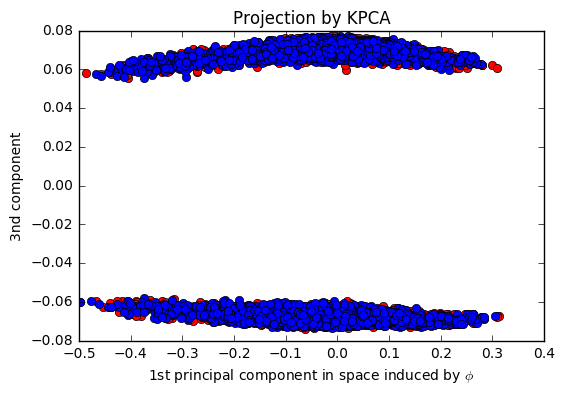

In [37]:
pcx = 0
pcy = 2
plt.plot(X_kpca[reds, pcx], X_kpca[reds, pcy], "ro")
plt.plot(X_kpca[blues, pcx], X_kpca[blues, pcy], "bo")
plt.title("Projection by KPCA")
plt.xlabel("%dst principal component in space induced by $\phi$"%(pcx+1))
plt.ylabel("%dnd component"%(pcy+1))

### Applying logistic classification log values of features

Below is the distribution

In [153]:
#df.hist("POL2_GSE65687",bins = 100,figsize = (10,10))
#some_feature = X[:,54]
#plt.figure(figsize = (10,10))
#plt.hist(some_feature+1,bins = 100)
#plt.hist(np.log10(some_feature+1),bins = 100)
#plt.show

In [77]:
np.log10(1e9)

9.0

In [33]:
threshold = 5000
print np.where(X[:,:70] > threshold,0.,1.).sum()/(X[:,:70].shape[0]*X[:,:70].shape[1])
X_binary = np.c_[np.where(X[:,:70] > threshold,0.,1.),X[:,70:]]
X_binary[0,:]

0.218564792105


array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,
        1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
        0.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,
        1.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,
        1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.])

### Applying SVM

In [157]:
# timing the SVM
t1 = time()
clf = make_pipeline(MinMaxScaler(), svm.SVC(C = 1,gamma=0.1))
clf.fit(X_train_log,y_train)
print "Training SVM took %.2f s." %(time()-t1)

Training SVM took 14.32 s.


In [162]:
print X_train_log.shape
clf.score(X_train_log,y_train)

(9902, 76)


0.59099171884467783

In [164]:
print X_test_log.shape
clf.score(X_test_log,y_test)

(2979, 76)


0.5501846257133266

In [ ]:
# perform the grid search to find the best parameters
clf = make_pipeline(MinMaxScaler(), svm.SVC())
print clf.get_params().keys()
parameters = {"svc__C":[1],"svc__gamma":[0.1,.2,.5]}
clf = GridSearchCV(clf, parameters,cv = 5)
clf.fit(X_train_log,y_train)

In [ ]:
# print the result of grid search
print clf.best_params_,clf.best_score_
cv_results = pd.DataFrame(clf.cv_results_)
cv_results
cv_results[['params',"mean_test_score","std_test_score",'rank_test_score']].sort_values(by="rank_test_score")

In [181]:
# cross validate the classifier using the best parameters
t1 = time()
cv = StratifiedKFold(n_splits=5)
clf = make_pipeline(MinMaxScaler(), svm.SVC(C = 1,gamma=0.1))
scores = cross_val_score(clf, X_train_log, y_train, cv=cv,n_jobs=-1)
print time()-t1

33.0519340038


In [180]:
# print the results of cross-validation
print scores       
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[ 0.55830389  0.5572943   0.55376073  0.58585859  0.57655382]
Accuracy: 0.57 (+/- 0.03)


In [168]:
#Train the classifer on the full training set
clf = make_pipeline(MinMaxScaler(), svm.SVC(C = 1,gamma=0.1))
clf.fit(X_train_log,y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [170]:
#Test the classifier on full test set
hSVM = clf.predict(X_test_log)
print "Accuracy of classifier is %.2f" %clf.score(X_test_log,y_test)

Accuracy of classifier is 0.55


In [173]:
metrics.accuracy_score(hRF,hSVM)

0.78147029204431018